In [161]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Loading The Titanic Dataset

In [162]:

#LOAD DATA
train = pd.read_csv('/kaggle/input/titanic/train.csv') #includes all the features and the target variable 'Survived' - 891 rows
test = pd.read_csv('/kaggle/input/titanic/test.csv') #includes the same features as the train dataset, but no 'Survived' column - 418 rows
full = pd.concat([train, test], sort=False) #Combine train and test datasets for consistent preprocessing


In [163]:
#Check the first 5 rows
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [164]:
#We also check about missing values, and print only the number of missing values
#in the corresponding columns
print('Number of missing values')
missing = pd.concat([train.isna().sum(), test.isna().sum()], axis=1)
missing.columns = ['train', 'test']
print(missing[missing.sum(axis=1) > 0]) 

Number of missing values
          train   test
Age         177   86.0
Fare          0    1.0
Cabin       687  327.0
Embarked      2    0.0


## Scaling & Normalization of Numerical Features

Since some features: 'Pclass', 'SibSp', 'Parch', 'Fare' have no missing values and require no encoding, we can apply a power transform directly to these variables directly, and then model the transformed data directly.

Next we create 4 subplots, one for each feature: Pclass, SibSp, Parch, and Fare.
For each feature it plots a histogram of the values (blue bars) and overlays a smoothed curve (in red) showing the average survival probability for each unique value.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

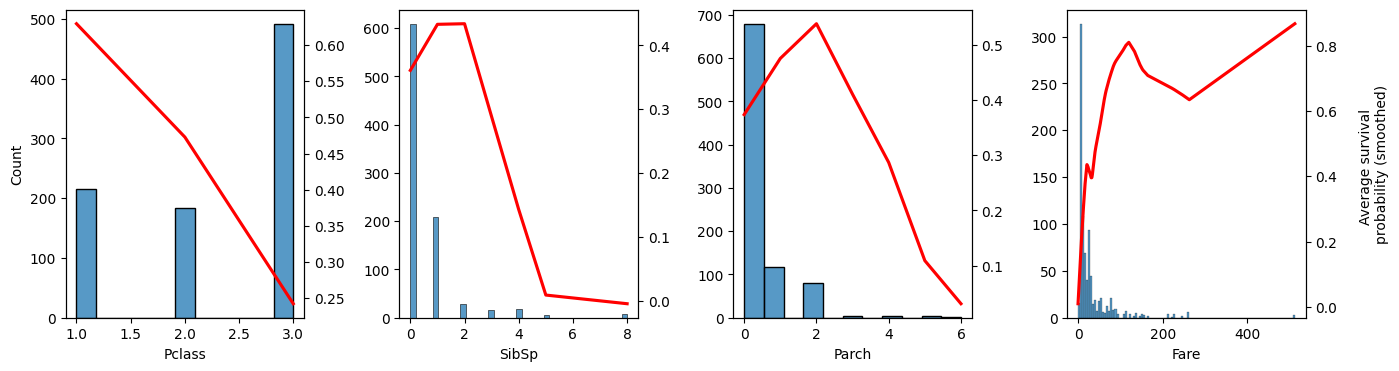

In [165]:
plt.figure(figsize=(16,4)) #overall figure size
plt.subplots_adjust(wspace=0.4) #spacing between subplots

#Loop over selected numerical values
for i,x in enumerate(['Pclass','SibSp', 'Parch', 'Fare']): 
    plt.subplot(1,4,i+1) #Create 1-row, 4-column subplot, and select the i-th
    
    sns.histplot(train[x]) #Plot the histogram of the feature
    
    group_mean = train.groupby(train[x])['Survived'].mean() ## Calculate average survival probability for each unique value
    
    ax = plt.gca() # Get current axes
    ax2=ax.twinx() # Create a second y-axis (for survival probability)

    # Plot smoothed red curve for survival probability
    sns.regplot(x=group_mean.index, y=list(group_mean),lowess=True,scatter=False, color='red')
    
    #Set y-axis labels
    if i == 0:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel('')
    if i == 3:
        ax2.set_ylabel('\nAverage survival \nprobability (smoothed)')

It is obvious from the histograms of the features we selected that these four variables are asymmetric. We will use PowerTransformer from sklearn to transform 'Fare'and we see that the distribution is more even, and it looks like the error in the logistic regression (just for this variable) is reduced.
Next, we will use QuantileTransformer from sklearn

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


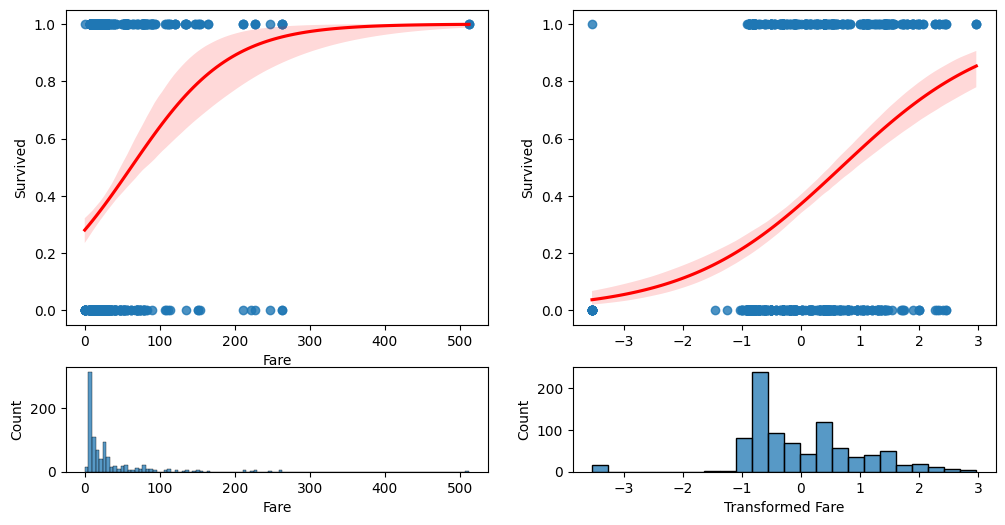

In [166]:
from sklearn.preprocessing import PowerTransformer

trainy = train['Survived']

# Create a 2x2 plot layout with bigger height on first row (regression plots)
f, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3,1]}, figsize=(12,6))

# Top-left: Logistic regression on raw 'Fare' vs Survived
_=sns.regplot(x=train['Fare'], y=trainy, logistic=True, line_kws={'color': 'red'}, ax=axes[0,0])

# Top-right: Logistic regression on transformed 'Fare' vs Survived
_=sns.regplot(x=PowerTransformer().fit_transform(train[['Fare']]), y=trainy, logistic=True, 
           line_kws={'color': 'red'}, ax=axes[0,1])
_=plt.gca().set_xlabel('Transformed Fare')

# Bottom-left: Histogram of raw 'Fare'
_=sns.histplot(x=train['Fare'],
            ax = axes[1,0])
_=plt.gca().set_xlabel('Fare')

# Bottom-right: Histogram of transformed 'Fare'
_=sns.histplot(x=PowerTransformer().fit_transform(train[['Fare']]).ravel(),
            ax = axes[1,1])
_=plt.gca().set_xlabel('Transformed Fare')


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (891). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


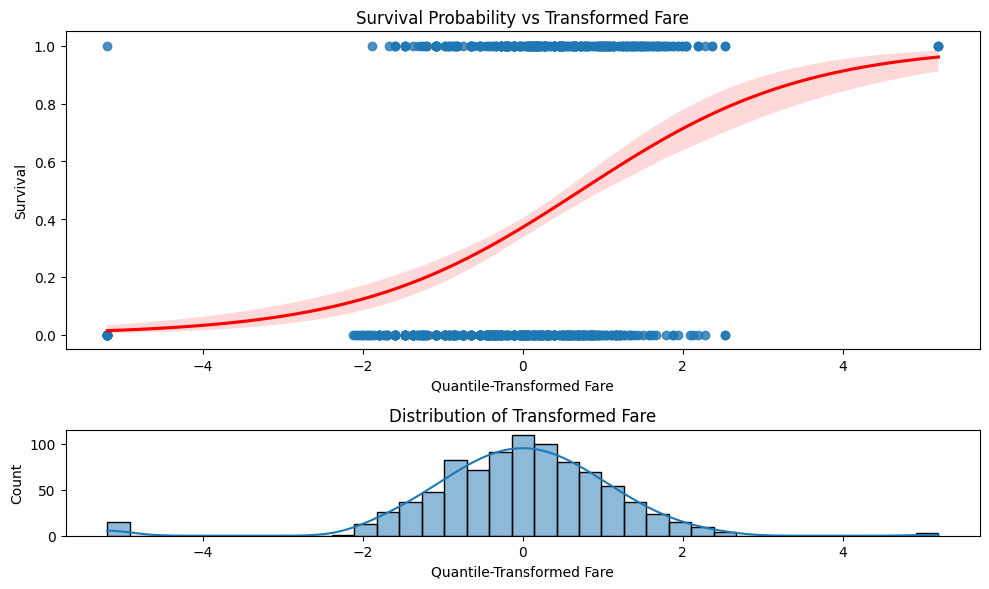

In [167]:
from sklearn.preprocessing import QuantileTransformer

trainy = train['Survived']
fare_qt = QuantileTransformer(output_distribution='normal').fit_transform(train[['Fare']]).ravel()

f, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})

sns.regplot(x=fare_qt, y=trainy, logistic=True, scatter=True, 
            line_kws={'color': 'red'}, ax=axes[0])
axes[0].set_title("Survival Probability vs Transformed Fare")
axes[0].set_ylabel("Survival")
axes[0].set_xlabel("Quantile-Transformed Fare")

sns.histplot(fare_qt, kde=True, ax=axes[1])
axes[1].set_xlabel("Quantile-Transformed Fare")
axes[1].set_title("Distribution of Transformed Fare")

plt.tight_layout()
plt.show()

So after plotting the Original Fare, the PowerTransformer-transformed Fare, and the QuantileTransformer-transformed Fare, each with a logistic regression plot (survival probability) and a histogram (distribution shape), we draw the following conclusions: The Original Fare, looks very skewed and the Logistic regression curve looks unbalanced. Using PowerTransformer, Distribution somewhat normalized, but not perfectly and the logistic curve is still a bit asymmetric.
However, using QuantileTransformer (Normal distribution) we get a Perfectly Gaussian distribution — symmetric bell shape and a logistic regression curve is clean, smooth, and balanced.

For the rest of the project we will use the Power Transformer on the four variables before fitting a logistic regression by first fitting a LogisticRegression on the raw data. Call cross_validate to get an estimate of the cross-validated error from using logistic regression. We use estimator=LogisticRegression():

In [168]:
#Imports the model and cross-validation utilities.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold

cv_mean_acc = cross_validate(estimator=LogisticRegression(), #Model: Logistic Regression
               scoring = 'accuracy', #Evaluation metric: Accuracy
               cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123), #CV: 5-fold stratified split
               X = train[['Pclass','SibSp', 'Parch', 'Fare']], # Features (raw, no preprocessing)
                             y=trainy)['test_score'].mean()  #Target variable (Survived)
print(f"Average cross-validated accuracy from logistic regression on raw data: {cv_mean_acc:.3f}")

Average cross-validated accuracy from logistic regression on raw data: 0.686


To define a pipeline, we just put the steps into a list and call the Pipeline constructor:



In [169]:
#Imports the Pipeline class so we can create a sequence of transformations followed by a model.
from sklearn.pipeline import Pipeline

simplest_pipeline = Pipeline(steps = [('normalize', PowerTransformer()), #The power transformation makes the data more Gaussian-like and reduces skewness
                                      ('lr_model', LogisticRegression())]) #Fits a logistic regression classifier on the normalized data.

Each step in a pipeline has a name (like "normalize" or "lr_model") and the correspoinding transformer or estimator. We can name the steps anything we want,but those names are useful because later on we can access or modify parameters of individual steps using set_params() or get_params() and tune hyperparameters inside each step using tools like GridSearchCV or RandomizedSearchCV

When we want to train (fit) the logistic regression on transformed data, we do not manually apply the transformation first. Instead, we pass the entire pipeline as the estimator to cross-validate and provide the raw input data, not the already transformed version. The pipeline takes care of both preprocessing and model fitting in each fold, automatically. So, next we are fitting and evaluating a normalized logistic regression model on the features ['Pclass','SibSp', 'Parch', 'Fare']  using a 10-fold stratified cross-validation in order to get a reliable avarage accuracy score.

In [170]:
#We create a Stratified K-Fold cross-validation splitter
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=124) #10 folds, stratified to ensure class balance, shuffling to randomize data before spliting and random_state to ensure reproducibility

cv_mean_acc_pipeline = cross_validate(
               estimator=simplest_pipeline,
               scoring = 'accuracy',
               cv = skf,
               X = train[['Pclass','SibSp', 'Parch', 'Fare']], y=trainy)['test_score'].mean() #Calculates the accuracy for each fold, and takes the avarage of the 10 accuracy scores.
print(f"Average cross-validated accuracy from logistic regression with transformed data: {cv_mean_acc_pipeline:.3f}")

Average cross-validated accuracy from logistic regression with transformed data: 0.713


Indeed, the cross-validated accuracy is improved!

## Imputing Missing Values 

Next, as we saw earlier there are features with missing values, so we will impute in a simple way by filling in with the mean value of the non-missing data.  

In [171]:
print('Number of missing values')
missing = pd.concat([train.isna().sum(), test.isna().sum()], axis=1) #Detect missing values in both train and test datasets.
missing.columns = ['train', 'test']
print(missing[missing.sum(axis=1) > 0]) 
print()

#The mean from the non-missing training and test data
print(f'Mean of non-missing Age column in training dataset: {train["Age"].mean():.1f}')
print(f'Mean of non-missing Age column in test dataset: {test["Age"].mean():.1f}')

Number of missing values
          train   test
Age         177   86.0
Fare          0    1.0
Cabin       687  327.0
Embarked      2    0.0

Mean of non-missing Age column in training dataset: 29.7
Mean of non-missing Age column in test dataset: 30.3


<Axes: >

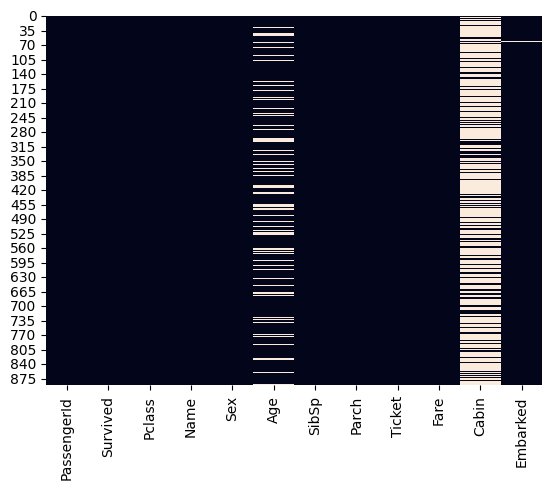

In [172]:
#Visualize missing data

#Import seaborn for data visualization
import seaborn as sns

sns.heatmap(train.isna(), cbar=False)

It is clear by now that the Cabin column has a huge amount of missing data (almost all entries). Age has also some missing values, scattered throughout, and Embarked has a couple of missing values. However, the other columns seem to be fully populated.

Next, since machine learning models cannot handle missing values (NaNs) on their own so before training we must either drop colums/rows with missing values or fill them in (imputation). At this point we will deal with imputation. In order to Impute we will use SimpleImputer from sklearn, by calling fit on the training data, then transform on the training data and then transform on the test data. We only fit on training data – never on test data – to prevent data leakage.
In the code below, we fill in the missing values in the 'Age' column of both the training and test datasets using the mean age from the training set. Later on, we will deal with the missing values of the Cabin column (Instead of imputing the missing cabin values (like with a mean or mode), we extract useful info from the values that do exist, and treat missing ones as a separate category.)


In [173]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') #Create an imputer that fills missing values using the mean of the column
imputed_train_Age = imputer.fit_transform(train[['Age']]) #Fit the imputer on the training data and transform it (fill missing values)
imputed_test_Age = imputer.transform(test[['Age']]) #Use the same mean from the training set to fill missing values in the test set


#Print the mean of the filled-in Age columns for both train and test datasets
print(f'Mean of imputed_train_Age: {imputed_train_Age.mean():.1f}')
print(f'Mean of imputed_test_Age: {imputed_test_Age.mean():.1f}')

Mean of imputed_train_Age: 29.7
Mean of imputed_test_Age: 30.2


Both values are likely very close, but may differ slightly due to different missing patterns

In [174]:
#Adjust the pipeline steps accordingly

#Create a pipeline
imputation_pipeline = Pipeline(steps=[ 
    ('impute', SimpleImputer(strategy='mean')),  #Handle missing Age values
    ('model', LogisticRegression())              #Train a model on the result
])
imputation_pipeline.fit(train[['Age']], trainy)

Pipeline(steps=[('impute', SimpleImputer()), ('model', LogisticRegression())])

## Encoding Categorical Variables

As we saw earlier, there are two categorical columns: 'Sex' and 'Embarked' which we will need to encode. We will use one-hot encoding to encode both columns and since we are trying to set up a pipeline it is best to consider a scikit-learn transformer approach to doing this. Then, we will train a model (Logistic Regression) on those encoded features using a pipeline

In [175]:
from sklearn.preprocessing import OneHotEncoder

# Create the encoder
one = OneHotEncoder(sparse_output=False, handle_unknown='ignore') #we set the handle_unknown to ingore, to avoid errors if test_data has unseen categories

pd.concat([train['Sex'], pd.DataFrame(one.fit_transform(train[['Sex']]), index=train.index)], axis=1) #Two indicator variables, one for male one for female


,Sex,0,1
0,male,0.0,1.0
1,female,1.0,0.0
2,female,1.0,0.0
3,female,1.0,0.0
4,male,0.0,1.0
...,...,...,...
886,male,0.0,1.0
887,female,1.0,0.0
888,female,1.0,0.0
889,male,0.0,1.0


Concatenation is just for visualizing the result (not used in model yet).

Apply the same for Embarked: (Again, concatenated with original column just to check results visually)

In [176]:
pd.concat([train['Embarked'], pd.DataFrame(one.fit_transform(train[['Embarked']]),
                                      index=train.index)], axis=1)

,Embarked,0,1,2,3
0,S,0.0,0.0,1.0,0.0
1,C,1.0,0.0,0.0,0.0
2,S,0.0,0.0,1.0,0.0
3,S,0.0,0.0,1.0,0.0
4,S,0.0,0.0,1.0,0.0
...,...,...,...,...,...
886,S,0.0,0.0,1.0,0.0
887,S,0.0,0.0,1.0,0.0
888,S,0.0,0.0,1.0,0.0
889,C,1.0,0.0,0.0,0.0


Then we create a a pipeline to automate encoding and modeling


In [177]:

encoding_pipeline = Pipeline(steps=[('encode', OneHotEncoder(handle_unknown='ignore')), #Encode categorical variables
                                    ('model', LogisticRegression())]) #Train logistic regression
encoding_pipeline.fit(train[['Sex', 'Embarked']], trainy) #Fit the pipeline: trains the full pipeline using 'Sex' and 'Embarked' columns. trainy is your target variable (Survived column)

Pipeline(steps=[('encode', OneHotEncoder(handle_unknown='ignore')),
                ('model', LogisticRegression())])

## Column-wise Transformations using ColumnTransformer

 Since there are different types of columns, each of these columns need different treatment. So, another way to deal with this is through applying different transformations to different columns. ColumnTransformer apply different preprocessing to different types of columns, which is essential since we are working with mixed data. So the goal here is to:
 
 Apply Imputation (mean), if we have Numerical features, apply encoding (OneHotEncoder), if we have Categorical features and leave the rest as they are (e.g 'Pclass').

 Note that OneHotEncoder handles missing categorical values (NaN) by treating them as a separate category.

In [178]:
from sklearn.compose import ColumnTransformer

multicolumn_prep = ColumnTransformer([
    #Impute missing values in numeric columns
    ('impute', 
     SimpleImputer(strategy='mean'), #Fill missing values using the column mean
     ['Age', 'Fare']), #Columns to apply the imputer on.
                            
    ('encode', 
     OneHotEncoder(handle_unknown='ignore'), #One-hot encode categorical values
     ['Sex', 'Embarked']), #Columns to apply the encoder on
],

#Let all the other columns pass through unchanged. Also ensures we don't drop useful columns that weren't explicitly mentioned.                                     
remainder='passthrough'
) #any column not specified in the transformer list (such as 'Pclass') will 'passthrough' the ColumnTransformer as specified by the remainder argument


multicolumn_prep

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute', SimpleImputer(), ['Age', 'Fare']),
                                ('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'Embarked'])])

The object multicolumn_prep can now be used as a preprocessing step inside a full pipeline with a model.

 Next we define a full machine learning pipeline with preprocessing and model training. 
 

In [179]:
ct_pipeline = Pipeline([
    #'preprocessing' includes imputation, one-hot encoding and pass-through
    ('preprocessing', multicolumn_prep),
    #Fit a Logistic regression model on the preprocessed data, with enough iterations to converge.
    ('lr_model', LogisticRegression(max_iter = 2000))])
ct_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute', SimpleImputer(),
                                                  ['Age', 'Fare']),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Embarked'])])),
                ('lr_model', LogisticRegression(max_iter=2000))])

Estimation of the accuracy from this preprocessing step combined with the logistic regression:


In [180]:
ct_cv_res = cross_validate(
    estimator = ct_pipeline, #preprocessing + logistic regression
    X = train.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis=1), #Drop irrelevant or unstructured features
    y = train['Survived'], #Target Variable
    cv = skf, #Stratified K-Fold cross-validation
    scoring = 'accuracy' #Evaluation metric: accuracy
)['test_score'].mean() #Average accuracy over all folds

print(f"Average cross-validated accuracy from\ncolumn transformer pipeline: {ct_cv_res:.3f}")

Average cross-validated accuracy from
column transformer pipeline: 0.793


Even better than the accuracy we scored earlier!

## Custom Feature Extraction from Cabin Column

As we saw earlier, the 'Cabin' column contians either a number e.g 'C85' or NaN if  the passenger wasn't in a cabin. The cabin number looks to consist of a deck 'A', 'B', 'C' and so on, and a number. Under the assumption that the deck could contain predictive information but the number on the deck won't, let's consider extracting the initial letter from this feature. The final target is to replace this column with a custom function.

In [181]:
train['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [182]:
#Extract the deck letter (NaN is considered a float)
[x[0] if type(x) == str else 'None' for x in train['Cabin']][:15] #If it is a string, take the first letter, else return 'None'.

#Take the first letter from each value in 'Cabin' column, and convert it to a number
#based on its position in the alphabet, if the value in not a string (e.g NaN return 0)
[ord(x[0]) - ord('A') + 1 if type(x) == str else 0 for x in train['Cabin']][:15]

[0, 3, 0, 3, 0, 0, 5, 0, 0, 0, 7, 3, 0, 0, 0]

However, if we want to approach this problem with a transformer, just like we replaced manual imputation with SimpleImputer in sklearn,
we now replace a manual list comprehension (to extract deck info from 'Cabin') with a more reusable approach using FunctionTransformer. FunctionTransformer() wraps your list comprehension into a pipeline-compatible transformer.

In [183]:
from sklearn.preprocessing import FunctionTransformer

#Define a custom transformation function to extract deck letters from 'Cabin' column
extract_cabin = FunctionTransformer(func = lambda col: np.array([ord(x[0]) - ord('A') + 1 \
                                                                 if type(x) == str else \
                                                                 0 for x in col
                                                                ])[:,np.newaxis] # reshape to column vector (n_samples, 1)

                                   )
extract_cabin.fit_transform(train['Cabin'])[:15]

array([[0],
       [3],
       [0],
       [3],
       [0],
       [0],
       [5],
       [0],
       [0],
       [0],
       [7],
       [3],
       [0],
       [0],
       [0]])

We created a FunctionTransformer to extract deck letters from the 'Cabin' column (like 'C85' → 3), using a list comprehension. Now, we want to use this in a ColumnTransformer, together with other transformations (like imputation, encoding). All transformers in the pipeline must produce columns, so they can be "glued together" side-by-side. So, we converted the 1D list into a 2D array using:
np.array(...)[..., np.newaxis]. That np.newaxis adds an extra dimension, turning shape from (n,) to (n, 1).

Now, we can combine this with the imputation and encoding in ColumnTransformer:

In [184]:
multicolumn_prep_with_cabin = ColumnTransformer([
    #Impute missing numerical values in 'Age' and 'Fare'
    ('impute', 
     SimpleImputer(strategy='mean'), 
     ['Age', 'Fare']),

    #Apply the extract_cabin transformer to the 'Cabin' column
     ('cabin_extract', 
      extract_cabin, 
      'Cabin'), #'Cabin' rather than ['Cabin']. If we had a true array function we could have the columns to be transformed in a list as with the other steps in the ColumnTransformer.

    #One-hot encode categorical features
     ('encode', 
      OneHotEncoder(handle_unknown='ignore',
      sparse_output=False), 
      ['Sex', 'Embarked'])
],
    remainder='passthrough') #Again, let all other columns (like 'Pclass', 'SibSp', 'Parch') pass through unchanged


multicolumn_prep_with_cabin

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute', SimpleImputer(), ['Age', 'Fare']),
                                ('cabin_extract',
                                 FunctionTransformer(func=<function <lambda> at 0x79ae83c18900>),
                                 'Cabin'),
                                ('encode',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Sex', 'Embarked'])])

Build a pipeline and evaluate accuracy with cross-validation:

In [185]:
#Check the new cross-validated accuracy: 
cv_with_cabin = cross_validate(
    estimator = Pipeline([
        ('preprocessing', multicolumn_prep_with_cabin), #Preprocessing pipeline
        ('lr', LogisticRegression(max_iter=2000)) #Model: Logistic Regression
    ]),
    X = train.drop(['Name', 'Ticket', 'Survived'], axis=1), #Input features (dropping irrelevant columns)
    y = train['Survived'],                                  #Target Variable
    cv = skf,                                               #Cross-validation strategy (StratifiedKFold)
    scoring = 'accuracy'                                    #Evaluation metric
)['test_score'].mean() #Get the average test accuracy across folds

print(f"Average cross-validated accuracy including 'Cabin' feature engineering: {cv_with_cabin:.3f}")

Average cross-validated accuracy including 'Cabin' feature engineering: 0.802


Another approach is the custom transformer. Moreover, we inherit from BestEstimator and TransformerMixin the fit_transform() (which autoruns fit() + transform()) and get_params() / set_params() (needed for things like GridSearchCV). If we'd like to specify a parameter for the transformation, we need to override the default __init__() method.

Although the names of passengers might not be directly useful, one idea is to extract the title (Mr, Miss, etc.) from the name, which we can encode, and perhaps this may be useful to a model. We pass in a 'min_relative_frequency' parameter into the call to the class (through __init__()), which thresholds the titles, replacing uncommon titles (such as 'Jonkheer') with 'Rare/Unknown'

In [186]:
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractTitle(BaseEstimator, TransformerMixin):

    #Define a custom transformer to extract titles from the 'Name' column
    def __init__(self, min_relative_freq):
        self.min_relative_freq = min_relative_freq #Parameter to control how rare a title must be to be grouped as 'Rare/Unknown'
    
    def fit(self, X, y=None):
        from collections import Counter
        title_freq = Counter() #Counter to store little frequencies
        titles = [x.split(',')[1].split('.')[0].strip() for x in X['Name']] #Extract titles from the 'Name' column (e.g., 'Mr', 'Mrs', 'Dr')
        title_freq.update(titles) #Count how often each title appears
        self.common_titles = [x[0] for x in title_freq.items() if x[1] > X.shape[0]*self.min_relative_freq] #Keep only common titles (those that appear more than threshold)
        return self
    
    def transform(self, X, y=None):
        #Re-extract titles (same logic as in fit)
        title = [x.split(',')[1].split('.')[0].strip() for x in X['Name']]
        X_copy = X.copy()
        X_copy['Title'] = [x if x in self.common_titles else 'Rare/Unknown' for x in title] #Replace uncommon titles with 'Rare/Unknown'
        return X_copy.drop(['Name'], axis=1) #Drop the original 'Name' column (no longer needed)

Rather than combining our transformer with ColumnTransformer, to replace the 'Name' column with 'Title', we add the processed column onto the dataframe and then drop the original column directly in the transform() method. The custom transformer approach is more flexible then the FunctionTransformer/ColumnTransformer combination, but the transformers usually end up being more specific to the task at hand, and hence less reusable.

Discretizing the 'Fare' numerical column.

Instead of using the raw Fare (which has a crazy range), we group it into categories like “cheap”, “average”, “expensive” — using pd.qcut() to keep the distribution balanced. And we do this inside a custom transformer because we want to plug it into a pipeline, but also we want to be able to tune the number of bins later (via GridSearchCV)

In [187]:
# Create a custom transformer class for discretizing 'Fare'
class QCutFare(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins): #number of bins as a parameter
        self.n_bins = n_bins
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        transformed = pd.qcut(X['Fare'], self.n_bins, labels=False) #pandas qcut to split 'Fare' into quantile-based bins
        transformed[transformed.isna()] = 0 #Replace any missing values (NaN) in the binned result with 0
        transformed_series = pd.Series(
            transformed, 
            name=f'QCut{self.n_bins}_Fare', #Dynamic column name like QCut13_Fare
            index=X.index
        )
        
        X_copy = X.copy() #Copy the original dataframe
        
        return pd.concat([X_copy, transformed_series], axis=1).drop(['Fare'], axis=1) #Add a new binned feature and drop the original Fare column
        
QCutFare(13).fit_transform(train)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,QCut13_Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,C,11
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,C123,S,10
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,NaN,S,3
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,NaN,S,5
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,B42,S,9
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,NaN,S,7
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,C148,C,9


We see that the 'Fare' column is replaced with the 'QCut13_Fare' column, which specifies which quantile-bin the fare belongs to. This way, we have removed skew from Fare, which is now more interpretable. So, Logistic Regression can now learn from this info easier


# Feature Engineering - Adding a Column

Sometimes, instead of just transforming or replacing existing columns, you might want to add new columns that summarize or combine information (like mean, variance etc) of multiple columns.

Custom transformers can achieve this by concatenating columns onto the 'X' matrix in the transform step.

In [188]:
np.unique(train['Age'])

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

We see that there are very small ages, such as 0.42, 0.67, etc. → which are probably babies under 1 year old. There are ages with halves (e.g. 20.5, 24.5, 55.5) → some put half the age, perhaps for accuracy or because they didn't know exactly. There are also many rounded ages (20, 30, 40, etc.)
The goal here it to create a new column named Fractinal Age, that indicates whether the age has a fractional (decimal) part. This may capture something specific or intentional about passengers who had more precise age records, and **it might have predictive power for survival.**

In [189]:
pd.DataFrame({'Age':train['Age'],
              'FractionalAge':[0 if np.isnan(x) else 1*(int(x)!=x) for x in train['Age']]}).loc[105:115,:] #This creates a new list by looping through each age (x) in the column
                                                                                                           #np.isnan(x): checks if x is missing (NaN). If it is, we return 0.
                                                                                                           #int(x) != x: checks if the age has a fractional part (e.g., 20.5 != 20 → True).
                                                                                                           #1 * (...): converts the boolean True/False into 1/0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Age,FractionalAge
105,28.0,0
106,21.0,0
107,NaN,0
108,38.0,0
109,NaN,0
110,47.0,0
111,14.5,1
112,22.0,0
113,20.0,0
114,17.0,0


We want to turn the previous list-comprehension logic that creates a FractionalAge feature into a reusable Scikit-learn-compatible custom transformer, so it can be used inside a pipeline, but we do not want to drop the original columns.

In [190]:

#Transformation of the list-comprehension approach into a scikit-learn transformer class.
from sklearn.base import TransformerMixin, BaseEstimator
class AddFractionalAgeColumn(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.concat([X, pd.Series([0 if np.isnan(x) else 1*(int(x)!=x) for x in X['Age']],
                                       index=X.index,
                                       name = 'FractionalAge')], axis=1) #Creates a new column called 'FractionalAge', concatenates it to the original DataFrame and returns the updated DataFrame.

In [191]:
#the transformer in action
AddFractionalAgeColumn().fit_transform(train).iloc[105:115,:]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FractionalAge
105,106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S,0
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S,0
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S,0
108,109,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S,0
109,110,1,3,"Moran, Miss. Bertha",female,NaN,1,0,371110,24.1500,NaN,Q,0
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S,0
111,112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,1
112,113,0,3,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,0
113,114,0,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,S,0
114,115,0,3,"Attalah, Miss. Malake",female,17.0,0,0,2627,14.4583,NaN,C,0


The output in the 'FractionalAge' column is identical to the output obtained from the list-comprehension approach we got earlier

Since traveling alone you are maybe less likely to survive, It would be useful to to know how big someone's family group is. So, we are combining 'SibSp' = Number of siblings/spouses on board and 'Parch' = Number of parents/children on board and adding +1 = The passenger themselves. This way, FamilySize = SibSp + Parch + 1.

In [192]:
#Custom transformer to add a new column that is the sum of selected columns
class AddSumOfColumnsColumn(BaseEstimator, TransformerMixin):

    #Constructor to define which columns to sum, what constant to add, and the name of the new column
    def __init__(self, columns, constant=0, name = 'AddedColumns'):
        self.columns = columns
        self.constant = constant
        self.name = name
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy() #We avoid changing the original DataFrame
        added_series = X[self.columns].sum(1) + self.constant # Calculate the sum of the selected columns row-wise, and add the constant
        added_series.name = self.name #Name the new Column
        return pd.concat([X, added_series], axis=1) #Concatenate the new column to the original DataFrame and return it

This way, our model can understand social stracture (alone, small family, big group).

In [193]:
#The transformer above in action
AddSumOfColumnsColumn(columns=['SibSp','Parch'],
                      constant=1,
                      name='FamilySize').fit_transform(train)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


This information might be useful, since passengers with small families or alone might have lower chances of survival, while large groups might stick together and help each other

# Drop Columns

So far in our pipeline we are dropping columns manually like 'Name' or "Ticket' before we pass the data into the pipeline. Now, we can build a transformer that drops columns inside the pipeline like we did in the previous steps (imputation, encoding). This will give us automation in the hyperparameter tuning, where we can use GridSearchCV to test.

In [194]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]): #Accept a list of columns to drop when initializing the class
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.drop(self.cols, axis=1) #Drop specified columns from the input DataFrame

# Named Transformer Output

It's time to combine the transformers we have developed so far into a pipeline that will be responsible for:
* Extracts the title and keeps only common titles (above 20% relative frequency), sets rare ones as "Rare/Unknown" and drops the original Name column
* Uses pd.qcut to split the Fare column into 13 quantile-based bins, transforming it into a categorical feature (QCut13_Fare).
* Adds a new binary column FractionalAge
* Creates a new feature called FamilySize
* Removes the Ticket column, as it’s noisy and non-informative
* Apply ColumnTransformer for Different Column Types as we saw earlier.

In [195]:
preprocessing_pipeline = Pipeline([

    #Extract common titles from Name (e.g., Mr, Miss, etc.)
    ('extract_title', ExtractTitle(min_relative_freq=0.2)),

    #Discretize Fare into 13 quantile-based bins
    ('discretize_Fare', QCutFare(13)),

    #Add a binary column indicating if Age has a decimal
    ('fractional_Age', AddFractionalAgeColumn()),

    #Create a new column 'FamilySize' = SibSp + Parch + 1
    ('family_Size', AddSumOfColumnsColumn(columns=['SibSp', 'Parch'], constant=1, name='FamilySize')),

    #Drop the 'Ticket' column
    ('drop', DropColumn(cols=['Ticket'])),

    #Apply column-specific transformations
    ('prep', ColumnTransformer([

        #Impute missing Age values with mean
        ('impute', SimpleImputer(strategy='mean'), ['Age']),

        #Extract deck info from Cabin
        ('cabin_extract', extract_cabin, 'Cabin'),

        #One-hot encode categorical variables
        ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         ['Sex', 'Embarked', 'Title'])

    ],
    #Pass through untouched columns (e.g., Pclass, FamilySize, QCut13_Fare, etc.)
    remainder='passthrough'))
])


Below, we take the full preprocessing_pipeline, and apply it to the training set, excluding 'Survived' column. We use fit_transform() to learn from the training data and apply those learned transformations to the data.

In [196]:
pd.DataFrame(preprocessing_pipeline.fit_transform(train.drop(['Survived'], axis=1)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,22.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0,2.0
1,38.000000,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,11.0,0.0,2.0
2,26.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,3.0,0.0,1.0
3,35.000000,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,0.0,10.0,0.0,2.0
4,35.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,3.0,0.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,887.0,2.0,0.0,0.0,5.0,0.0,1.0
887,19.000000,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,888.0,1.0,0.0,0.0,9.0,0.0,1.0
888,29.699118,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,889.0,3.0,1.0,2.0,7.0,0.0,4.0
889,26.000000,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,890.0,1.0,0.0,0.0,9.0,0.0,1.0


Next, we take the already fitted pipeline to transform the test set. Obviously we call only transform() and not fit_transform() since we should never fit on the test set.

In [197]:
pd.DataFrame(preprocessing_pipeline.transform(test))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,34.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,892.0,3.0,0.0,0.0,2.0,1.0,1.0
1,47.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,893.0,3.0,1.0,0.0,0.0,0.0,2.0
2,62.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,894.0,2.0,0.0,0.0,4.0,0.0,1.0
3,27.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,895.0,3.0,0.0,0.0,4.0,0.0,1.0
4,22.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,896.0,3.0,1.0,1.0,5.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,29.699118,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1305.0,3.0,0.0,0.0,3.0,0.0,1.0
414,39.000000,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1306.0,1.0,0.0,0.0,12.0,0.0,1.0
415,38.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1307.0,3.0,0.0,0.0,0.0,1.0,1.0
416,29.699118,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1308.0,3.0,0.0,0.0,3.0,0.0,1.0


When we use custom transformers (the ones we wrote with transform()), the column names stay intact, since we returned a proper pandas Dataframe. However, when we use built-in transformers, like OneHotEncoder or ColumnTransformer, they often return a NumPy array, which has no column names

In [198]:
Pipeline(preprocessing_pipeline.steps[:-1]).fit_transform(train.drop(['Survived'], axis=1))

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Title,QCut13_Fare,FractionalAge,FamilySize
0,1,3,male,22.0,1,0,NaN,S,Mr,1,0,2
1,2,1,female,38.0,1,0,C85,C,Rare/Unknown,11,0,2
2,3,3,female,26.0,0,0,NaN,S,Miss,3,0,1
3,4,1,female,35.0,1,0,C123,S,Rare/Unknown,10,0,2
4,5,3,male,35.0,0,0,NaN,S,Mr,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,male,27.0,0,0,NaN,S,Rare/Unknown,5,0,1
887,888,1,female,19.0,0,0,B42,S,Miss,9,0,1
888,889,3,female,NaN,1,2,NaN,S,Miss,7,0,4
889,890,1,male,26.0,0,0,C148,C,Mr,9,0,1


When we use things like ColumnTransformer, SimpleImputer, OneHotEncoder, etc,  they transform our data, but return a NumPy array, not a DataFrame

That means: No column names, we can’t easily tell which feature is which, we can’t map back to the original DataFrame and Debugging & feature importance becomes a nightmare.
So we will need to rewrite the extract_cabin transformer using FunctionTransformer to return a data frame (ignore the warning).

In [199]:
extract_cabin_named = FunctionTransformer(func = lambda df: df.apply(lambda col: [ord(x[0]) - ord('A') + 1 if type(x) == str else 0 for x in col])).set_output(transform="pandas")
extract_cabin_named.fit_transform(train[['Cabin']])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,Cabin
0,0
1,3
2,0
3,3
4,0
...,...
886,0
887,2
888,0
889,3


Now, we can get named output by appending .set_output(transform='pandas') onto the ColumnTransformer. (The set_output method looks like it recursively applies itself to subtransformations.)

In [200]:
#all the transformers stay the same as previously
named_preprocessing_pipeline = Pipeline([('extract_title', ExtractTitle(min_relative_freq = 0.2)),
                                         ('discretize_Fare', QCutFare(13)),
                                         ('fractional_Age', AddFractionalAgeColumn()),
                                         ('family_Size', AddSumOfColumnsColumn(columns=['SibSp','Parch'],
                                                                               constant=1,
                                                                               name='FamilySize')),
                                         ('drop', DropColumn(cols=['Ticket'])),
                                         ('prep',ColumnTransformer([('impute', 
                                                                          SimpleImputer(strategy='mean'), 
                                                                          ['Age']),
                                                                         ('cabin_extract', 
                                                                          extract_cabin_named, 
                                                                          ['Cabin']),
                                                                         ('encode', 
                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                        sparse_output=False), 
                                                                          ['Sex', 'Embarked', 'Title']),
                                                                        ],
                                                                        remainder='passthrough').set_output(transform='pandas')),
                                         ])
named_preprocessing_pipeline

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('extract_title', ExtractTitle(min_relative_freq=0.2)),
                ('discretize_Fare', QCutFare(n_bins=13)),
                ('fractional_Age', AddFractionalAgeColumn()),
                ('family_Size',
                 AddSumOfColumnsColumn(columns=['SibSp', 'Parch'], constant=1,
                                       name='FamilySize')),
                ('drop', DropColumn(cols=['Ticket'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute', SimpleImputer(),
                                                  ['Age']),
                                                 ('cabin_extract',
                                                  FunctionTransformer(func=<function <lambda> at 0x79ae8a272160>),
                                                  ['Cabin']),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Embarked',
                                                   'Title'])]))])

In [201]:
named_preprocessing_pipeline.fit_transform(train.drop(['Survived'], axis=1))

,impute__Age,cabin_extract__Cabin,encode__Sex_female,encode__Sex_male,encode__Embarked_C,encode__Embarked_Q,encode__Embarked_S,encode__Embarked_nan,encode__Title_Miss,encode__Title_Mr,encode__Title_Rare/Unknown,remainder__PassengerId,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__QCut13_Fare,remainder__FractionalAge,remainder__FamilySize
0,22.000000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,3,1,0,1,0,2
1,38.000000,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1,1,0,11,0,2
2,26.000000,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,3,0,0,3,0,1
3,35.000000,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4,1,1,0,10,0,2
4,35.000000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5,3,0,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,887,2,0,0,5,0,1
887,19.000000,2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,888,1,0,0,9,0,1
888,29.699118,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,889,3,1,2,7,0,4
889,26.000000,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,890,1,0,0,9,0,1


# Modeling using the Pipeline!

The final step is attaching a model onto the end of the pipeline. Let's use LogisticRegression again, with a normalization step just before the model:

In [202]:
from sklearn.preprocessing import StandardScaler

#Build final pipeline which includes preprocessing, scale, and fit logistic regression
#We also add the StandardScaler for models that need feature scaling.
#Lastly we add the final Logistic Regression model.
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + \
                              [('scale',StandardScaler().set_output(transform='pandas')), 
                               ('logreg', LogisticRegression(max_iter=2500))])  
modelling_pipeline  

Pipeline(steps=[('extract_title', ExtractTitle(min_relative_freq=0.2)),
                ('discretize_Fare', QCutFare(n_bins=13)),
                ('fractional_Age', AddFractionalAgeColumn()),
                ('family_Size',
                 AddSumOfColumnsColumn(columns=['SibSp', 'Parch'], constant=1,
                                       name='FamilySize')),
                ('drop', DropColumn(cols=['Ticket'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute', SimpleImputer(),
                                                  ['Age']),
                                                 ('cabin_extract',
                                                  FunctionTransformer(func=<function <lambda> at 0x79ae8a272160>),
                                                  ['Cabin']),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=2500))])

In [203]:
#Fit the full pipeline to the training data
modelling_pipeline.fit(
    X=train.drop(['Survived'], axis=1),  #Remove target column (we only want features)
    y=train['Survived']                  #This is the target variable (1 = survived, 0 = not)
)

# Make predictions on the test dataset using the fitted pipeline
predictions = modelling_pipeline.predict(test)  #returns a list of 0s and 1s

#Load the sample submission file from Kaggle 
sample = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

#Replace the 'Survived' column in the sample with your model's predictions
sample['Survived'] = predictions

#Save the new DataFrame as a CSV so you can submit it to Kaggle
sample.to_csv('accuracy_submission.csv', index=False)


Next, we will evaluate our entire modeling pipeline (modelling_pipeline) using cross-validation on the Titanic dataset, and print the average cross-validated accuracy across folds.

In [204]:
#Perform cross-validation using the final modeling pipeline
pipeline_cv = cross_validate(
    estimator = modelling_pipeline,                 # The complete pipeline
    X = train.drop(['Survived'], axis=1),           # Input features (dropping the target column 'Survived')
    y = train['Survived'],                          # Target values (whether the passenger survived)
    cv = skf,                                       # Cross-validation strategy 
    scoring = 'accuracy'                            # Metric to evaluate: accuracy
)


In [205]:
# Print the average accuracy across all CV folds
print(f"Average cross-validated accuracy from final pipeline: {pipeline_cv['test_score'].mean():.3f}")


Average cross-validated accuracy from final pipeline: 0.813


Let's have a look at the features that were most importart in the logistic regression model, plotting a bar chart. 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


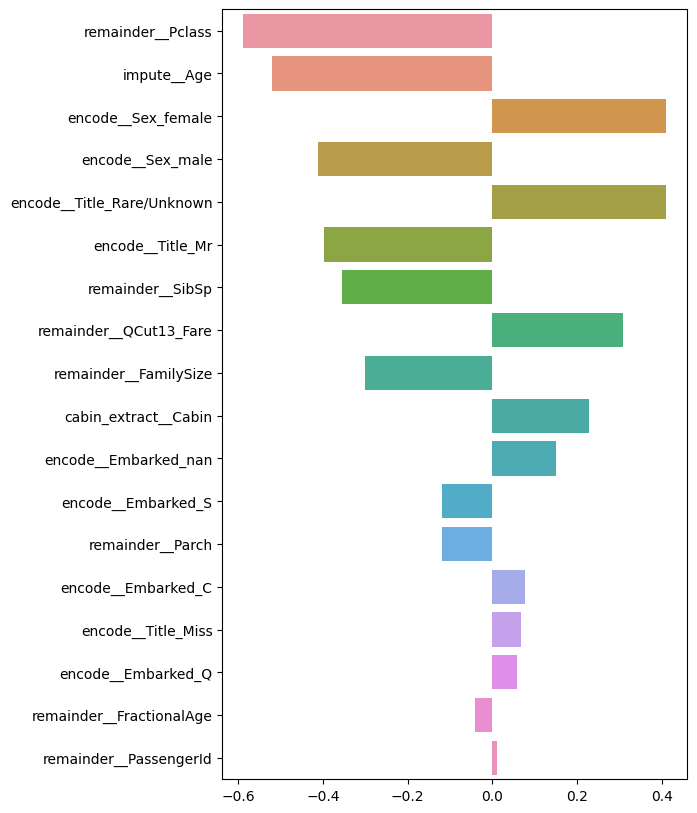

In [206]:
trainX = train.drop('Survived', axis=1)
trainy = train['Survived']

plt.figure(figsize=(6,10))
modelling_pipeline.fit(trainX, trainy)

x_plt = modelling_pipeline.steps[-1][1].coef_.ravel()
x_plt_abs = np.abs(x_plt)
y_plt = Pipeline(modelling_pipeline.steps[:-1]).fit_transform(trainX).columns
_,xp,yp=list(zip(*sorted(list(zip(x_plt_abs, x_plt, y_plt)), 
                                  reverse=True)))

_=sns.barplot(x=list(xp),y=list(yp))

As we can see, young female passengers who paid a larger fare are more likely to survive than poor male passengers.

Since the 'FractionalAge' feature that we engineered earlier doesn't seem to be useful, maybe we should get rid of it. We will use set_params() to dynamically enable/disable steps.

In [207]:
modelling_pipeline.set_params(fractional_Age=None)

Pipeline(steps=[('extract_title', ExtractTitle(min_relative_freq=0.2)),
                ('discretize_Fare', QCutFare(n_bins=13)),
                ('fractional_Age', None),
                ('family_Size',
                 AddSumOfColumnsColumn(columns=['SibSp', 'Parch'], constant=1,
                                       name='FamilySize')),
                ('drop', DropColumn(cols=['Ticket'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute', SimpleImputer(),
                                                  ['Age']),
                                                 ('cabin_extract',
                                                  FunctionTransformer(func=<function <lambda> at 0x79ae8a272160>),
                                                  ['Cabin']),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=2500))])

Let's now compare Pipeline with fractinal_age feature and without.

In [208]:
X = train.drop('Survived', axis=1)
y = train['Survived']

# Pipeline WITH fractional_Age feature
acc_with = cross_validate(modelling_pipeline, X, y, cv=skf)['test_score'].mean()

# Pipeline WITHOUT fractional_Age feature
modelling_pipeline.set_params(fractional_Age=None)
acc_without = cross_validate(modelling_pipeline, X, y, cv=skf)['test_score'].mean()

print(f"Accuracy with FractionalAge: {acc_with:.3f}")
print(f"Accuracy without FractionalAge: {acc_without:.3f}")

Accuracy with FractionalAge: 0.813
Accuracy without FractionalAge: 0.813


Our custom feature FractinalAge doesn't actually help the model, since it made no difference to our cross-validated accuracy.

# Evaluating Preprocessing Strategies with GridSearchCV

To optimize our model’s hyperparameters and preprocessing choices, we use GridSearchCV wrapped around a full pipeline containing both preprocessing and classification steps

The goal is to use GridSearchCV to try different model hyperparameters, turn on or off steps (like FractionalAge) and to find the best combo to maximize accuarcy. Here we:
1. Tune the regularization parameter of the logistic regression with 'logreg__C' parameter (the 'logreg' is from the name associated with the LogisticRegression step of the pipeline, and the 'C' refers to the logistic regression regularization parameter.
2. choose whether the fractional age indicator feature engineering should be included (setting a step to None turns this step off)
3. swap out the mean imputation strategy for a median imputation strategy (notice the chain of parameter naming to access the SimpleImputer strategy here), and
4. Choose the number of bins to discretize 'Fare' with.

In [209]:
%%time
from sklearn.model_selection import GridSearchCV #automates model + hyperparameter selection through cross-validation.

gscv_roc = GridSearchCV(estimator = modelling_pipeline, ## Pipeline with preprocessing and Logistic Regression
                        cv = skf, #Cross-validation strategy
                        scoring='roc_auc', #Metric to optimize = ROC-AUC (good for binary classification 0/1)
                        verbose=0, #No verbosity. Set to 1/2/3 to see more output during fitting
                        
                        param_grid = {'logreg__C': [0.001,1,1000], #Logistic Regression regularization strength
                                      'fractional_Age': [None,AddFractionalAgeColumn()], #We select NOT to include 'FractionalAge'
                                      'prep__impute__strategy': ['mean', 'median'], #Try different imputation strategies
                                      'discretize_Fare__n_bins': [5,13],  #Binning the 'Fare' column into 5 or 13 groups
                                     },
                       )
_=gscv_roc.fit(X = train.drop(['Survived'], axis=1),
               y = train['Survived'],
              )

CPU times: user 2min 49s, sys: 127 ms, total: 2min 49s
Wall time: 43.4 s


Instead of just using accuracy to compare model performance in GridSearchCV, we switched to ROC AUC because accuracy scores on Titanic are often very close and unhelpful.
ROC_AUC measures the model's ability to rank positive (survived) vs negative (not survived) cases. Also, takes into account true positives and false positives at every threshold.

Let's now display cv_results as a table, and choose the best hyperparameters combo!

In [210]:
import pandas as pd

# Convert the cv_results_ dictionary into a DataFrame
cv_results_df = pd.DataFrame(gscv_roc.cv_results_)

# Select relevant columns for display
cols_to_display = [
    'mean_test_score', 'rank_test_score',
    'param_logreg__C',
    'param_fractional_Age',
    'param_prep__impute__strategy',
    'param_discretize_Fare__n_bins'
]

# Sort by best score (rank = 1 is the best)
cv_results_df_sorted = cv_results_df[cols_to_display].sort_values(by='rank_test_score')

# Show top 10 configurations
cv_results_df_sorted.head(10)


,mean_test_score,rank_test_score,param_logreg__C,param_fractional_Age,param_prep__impute__strategy,param_discretize_Fare__n_bins
5,0.863261,1,1000,None,median,5
3,0.863259,2,1,None,median,5
2,0.863209,3,1,None,mean,5
15,0.863148,4,1,None,median,13
14,0.863091,5,1,None,mean,13
4,0.862994,6,1000,None,mean,5
16,0.862609,7,1000,None,mean,13
17,0.862291,8,1000,None,median,13
21,0.862188,9,1,AddFractionalAgeColumn(),median,13
10,0.862087,10,1000,AddFractionalAgeColumn(),mean,5


**Top performing Config:**
* ROC-AUC:     **0.863261**
* logreg__C:   1000
* FractionalAge: not used (None)
* Imputation:  median
* Fare bins:   5

Summary of how each individual hyperparameter affects performance — by isolating each parameter and calculating the mean ROC-AUC score for each of its values across the GridSearchCV results:

In [215]:
cv_res = pd.DataFrame({
    param: gscv_roc.cv_results_[f'param_{param}']
    for param in gscv_roc.param_grid
})
cv_res['mean_cross_validated_ROC_AUC'] = gscv_roc.cv_results_['mean_test_score']
cv_res['rank'] = gscv_roc.cv_results_['rank_test_score']

for pname in gscv_roc.param_grid:
    print(f'--- {pname} ---')
    print(cv_res.groupby(pname)['mean_cross_validated_ROC_AUC'].mean())
    print('')

--- logreg__C ---
logreg__C
0.001       0.855215
1.000       0.862604
1000.000    0.862322
Name: mean_cross_validated_ROC_AUC, dtype: float64

--- fractional_Age ---
fractional_Age
AddFractionalAgeColumn()    0.859614
Name: mean_cross_validated_ROC_AUC, dtype: float64

--- prep__impute__strategy ---
prep__impute__strategy
mean      0.860071
median    0.860023
Name: mean_cross_validated_ROC_AUC, dtype: float64

--- discretize_Fare__n_bins ---
discretize_Fare__n_bins
5     0.860169
13    0.859925
Name: mean_cross_validated_ROC_AUC, dtype: float64



**Recap**

We used a pipeline-based approach with GridSearchCV to:

-Combine preprocessing and modeling into a single pipeline

-Automatically explore combinations of feature engineering & model hyperparameters

-Evaluate them with cross-validated ROC-AUC scores

-Identify the most predictive configuration

**More detailed information**

- Logistic Regression (C=1000):

    Higher C = less regularization → the model can better fit the data.

    This suggests strong signal in the engineered features — we want the model to leverage them fully.

- Fractional Age Feature:

    Did not improve performance overall.

    It might be noisy or redundant given other features like 'Age', 'Title', or 'Pclass'.

- Imputation Strategy:

    mean and median performed similarly, but median had a slight edge.

    Median is often more robust to outliers, which aligns well with skewed features like Fare.

- Fare Discretization:

    5 bins > 13 bins.

    Simpler grouping is more effective — perhaps because the Fare distribution is already skewed, and too many bins dilute the signal.

##  Final Evaluation & Submission

We trained multiple models and performed feature engineering. Our best model achieved an accuracy of **0.863261%** on the validation set. Next steps include:

- Improving cross-validation strategy (e.g., nested CV)
- Trying more classifiers (e.g., LightGBM, SVC)
- Handling class imbalance

We also generate a CSV submission file for Kaggle leaderboard evaluation.


In [212]:
#Create Kaggle submission file
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
submission['Survived'] = predictions
submission.to_csv('submission.csv', index=False)

print("Submission file created!")

Submission file created!
